## Import Modules

In [1]:
import json
import numpy as np
import os
import time
import socket
from pathlib import Path
import cv2

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pixel_generator.mage import models_mage
from PIL import Image

from imagenet_clstolabel import IMGNET_CLASS2LABEL

from IPython.display import display

/data/scratch-oc40/lth/anaconda3/envs/rcg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def viz_torchimage(image):
    image = torch.clamp(image, 0, 1)
    image_np = image.detach().cpu().numpy().transpose([1, 2, 0])
    image_np = Image.fromarray(np.uint8(image_np*255))
    display(image_np)

## Load pre-trained encoder, RDM and MAGE

In [3]:
# Initialize RCG-L
class_cond = False
if class_cond:
    rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitl-clscond.pth'
    rdm_cfg = 'config/rdm/mocov3vitl_simplemlp_l12_w1536_classcond.yaml'
else:
    rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitl.pth'
    rdm_cfg = 'config/rdm/mocov3vitl_simplemlp_l12_w1536.yaml'
model = models_mage.mage_vit_large_patch16(mask_ratio_mu=0.75, mask_ratio_std=0.25,
                                           mask_ratio_min=0.5, mask_ratio_max=1.0,
                                           vqgan_ckpt_path='vqgan_jax_strongaug.ckpt',
                                           use_rep=True, rep_dim=256, rep_drop_prob=0.1,
                                           use_class_label=False,
                                           pretrained_enc_arch='mocov3_vit_large',
                                           pretrained_enc_path='pretrained_enc_ckpts/mocov3/vitl.pth.tar',
                                           pretrained_enc_proj_dim=256,
                                           pretrained_enc_withproj=True,
                                           pretrained_rdm_ckpt=rdm_ckpt_path,
                                           pretrained_rdm_cfg=rdm_cfg)

Use representation as condition!
Loading model from final_ckpts/rdm-mocov3vitl.pth
RDM: Running in x0-prediction mode
DiffusionWrapper has 62.72 M params.
Keeping EMAs of 132.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Strict load
Restored from vqgan_jax_strongaug.ckpt


In [4]:
checkpoint = torch.load(os.path.join('final_ckpts/mage-l.pth'), map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)
model.cuda()
_ = model.eval()

## Image Generation

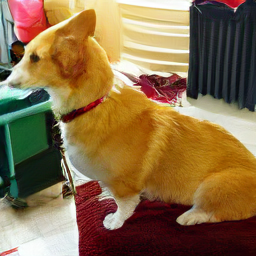

In [5]:
torch.manual_seed(7)
np.random.seed(7)

n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0

if class_cond:
    for class_label in [1, 323, 985]:
        print("{}: {}".format(class_label, IMGNET_CLASS2LABEL[class_label]))
        class_label = class_label * torch.ones(1).cuda().long()
        for i in range(n_image_to_gen):
            gen_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=None, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=class_label)
            viz_torchimage(gen_images[0])

else:
    for i in range(n_image_to_gen):
        gen_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=None, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
        viz_torchimage(gen_images[0])

## GT Representation Reconstruction

### Initialize data loader

In [6]:
# get train loader
torch.manual_seed(0)
np.random.seed(0)
bsz = 1
transform = transforms.Compose([
            transforms.Resize(256, interpolation=3),
            transforms.CenterCrop(256),
            transforms.ToTensor()])

dataset = datasets.ImageFolder('data/imagenet/val', transform=transform)
data_loader = torch.utils.data.DataLoader(
        dataset,
        shuffle=True,
        batch_size=bsz,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
)
data_iterator = enumerate(data_loader)

### Generate Image from GT Representation

Ground Truth Image:


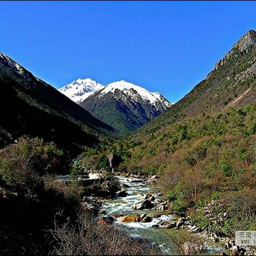

Reconstructed Images:


/data/scratch-oc40/lth/anaconda3/envs/rcg/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


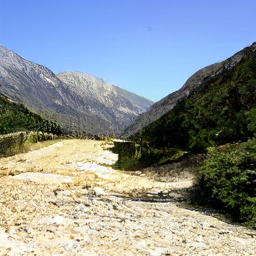

In [7]:
n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 0.0

_, (images, _) = next(data_iterator)

images = images.cuda()
print("Ground Truth Image:")
viz_torchimage(images[0])

with torch.no_grad():
    mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    std = torch.Tensor([0.229, 0.224, 0.225]).cuda().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    x_normalized = (images - mean) / std
    x_normalized = torch.nn.functional.interpolate(x_normalized, 224, mode='bicubic')
    rep = model.pretrained_encoder.forward_features(x_normalized)
    if model.pretrained_enc_withproj:
        rep = model.pretrained_encoder.head(rep)
    rep_std = torch.std(rep, dim=1, keepdim=True)
    rep_mean = torch.mean(rep, dim=1, keepdim=True)
    rep = (rep - rep_mean) / rep_std

print("Reconstructed Images:")
recon_image_list = []
for _ in range(n_image_to_gen):
    recon_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=rep, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
    viz_torchimage(recon_images[0])
